In [25]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp")

S = 512

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * B[k, j])

    return [C]

mmul = tf.program(matmul)

TensorProgram:
  Kernel count: 2
  Intermediate buffers: 5
  Lines of generated code: 122
  IR size: 26



In [26]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[145.09773  136.5571   138.00142  ... 135.6475   142.80664  140.48456 ]
 [132.57826  127.10102  122.75875  ... 125.80411  128.47295  129.68535 ]
 [139.52205  132.49057  132.5232   ... 133.30171  136.95815  131.37253 ]
 ...
 [132.2939   124.857956 124.82685  ... 122.39903  123.49251  124.96354 ]
 [134.45863  129.53177  130.01976  ... 127.251625 130.58366  130.6225  ]
 [130.46796  125.23402  126.04877  ... 124.94294  125.71752  128.51665 ]]
[[145.09764  136.55711  138.0015   ... 135.6476   142.80661  140.48454 ]
 [132.57819  127.10106  122.75877  ... 125.80413  128.47296  129.68542 ]
 [139.52206  132.49057  132.52312  ... 133.30174  136.95818  131.37248 ]
 ...
 [132.29388  124.858    124.82683  ... 122.398994 123.49251  124.96355 ]
 [134.45862  129.53168  130.01974  ... 127.25163  130.58363  130.62247 ]
 [130.468    125.23401  126.04878  ... 124.942955 125.71749  128.51668 ]]
[[ 9.1552734e-05 -1.5258789e-05 -7.6293945e-05 ... -9.1552734e-05
   3.0517578e-05  1.5258789e-05]
 [ 7.6293945e

In [27]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

# Performance test
t0 = time.time()
for i in range(25):
    C, = mmul(A, B)
t1 = time.time()

tf_time = t1 - t0
print("TensorFrost: ", t1 - t0)

t0 = time.time()
for i in range(25):
    Cnp2 = Bnp @ Anp
t1 = time.time()

np_time = t1 - t0
print("Numpy: ", t1 - t0)

print("TF/NP: ", tf_time / np_time)

TensorFrost:  1.5329995155334473
Numpy:  0.031000375747680664
TF/NP:  49.45099788502211


In [28]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    t0 = time.time()
    for i in range(2**14//S):
        C, = mmul(A, B)
    t1 = time.time()

    tf_time = t1 - t0

    t0 = time.time()
    for i in range(2**14//S):
        Cnp2 = Bnp @ Anp
    t1 = time.time()

    np_time = t1 - t0

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

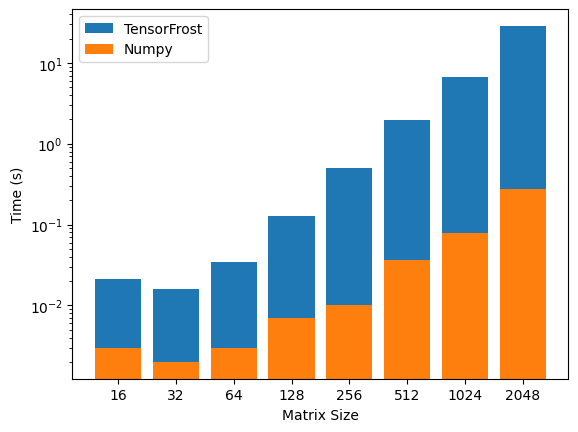

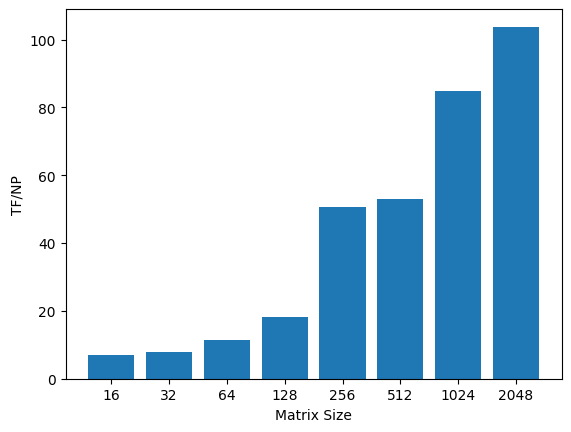

[0.020999908447265625, 0.01600050926208496, 0.03399968147277832, 0.12799978256225586, 0.5059998035430908, 1.9649996757507324, 6.710999250411987, 28.745999574661255]
[0.0029997825622558594, 0.0019996166229248047, 0.0030019283294677734, 0.007000446319580078, 0.010000944137573242, 0.03699994087219238, 0.07900190353393555, 0.27699995040893555]


In [29]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)